In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error

In [3]:
data = pd.read_csv('/workspaces/regularized-linear-regression/data/raw/demohealth-raw.csv')
data.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [4]:
data = data.drop_duplicates().reset_index(drop = True)

In [5]:
data.isnull().any().any()

False

Escalado de datos

In [7]:
data_types = data.dtypes
numeric_columns = [c for c in list(data_types[data_types != "object"].index) if c != "anycondition_number"]

scaler = StandardScaler()
norm_features = scaler.fit_transform(data[numeric_columns])

# Crear un nuevo DataFrame con las variables numéricas escaladas
data_scal = pd.DataFrame(norm_features, index = data.index, columns = numeric_columns)
data_scal["anycondition_number"] = data["anycondition_number"]
data_scal.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code,anycondition_number
0,-1.940874,-0.145679,-0.142421,0.158006,-0.135556,0.573496,-0.153144,0.027610,-0.139384,0.588469,...,-0.063696,-0.071720,-0.089834,-0.129902,-0.609615,-0.582796,-0.669652,-0.147523,-1.082865,20181
1,-1.940742,0.341296,0.287476,-0.242861,0.320383,-0.193107,0.183774,-0.469965,0.230620,-0.110300,...,-0.394103,-0.414900,-0.337677,0.376251,-0.433549,-0.393279,-0.343373,0.389791,-0.420704,68790
2,-1.940610,-0.237785,-0.239429,-0.419441,-0.246181,-0.439718,-0.225971,0.272104,-0.218759,0.656538,...,2.432709,2.483064,2.317776,-0.183415,1.855312,1.880929,1.777443,-0.204321,0.903618,11325
3,-1.940478,-0.245223,-0.246032,-0.426966,-0.254791,-0.609076,-0.230792,0.396168,-0.220555,1.264959,...,0.376846,0.423984,0.299632,-0.229096,-0.257483,-0.203761,-0.180233,-0.242100,-1.745026,9190
4,-1.940346,-0.138966,-0.135053,0.186249,-0.137140,0.216679,-0.155888,-0.200808,-0.143570,0.088582,...,0.156575,0.195197,0.158008,-0.111247,-0.081417,-0.014244,-0.017093,-0.124105,-1.745026,20584


División y selección de características

In [8]:
X =data_scal.drop(columns=["anycondition_number"])
y = data_scal["anycondition_number"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
train_indices = list(X_train.index)
test_indices = list(X_test.index)

In [12]:

k = int(len(X_train.columns) * 0.3)
selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()

X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,...,Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),Total Population,Population Aged 60+,county_pop2018_18 and older,Obesity_number,Heart disease_number,COPD_number,diabetes_number,CKD_number
0,-0.232556,-0.227731,-0.234284,-0.232951,-0.226353,-0.231316,-0.229599,-0.233425,-0.234680,-0.234420,...,-0.212643,-0.208590,-0.231195,-0.229737,-0.233171,-0.232975,-0.225814,-0.223516,-0.218609,-0.219329
1,-0.158676,-0.178665,-0.180166,-0.188266,-0.175070,-0.161168,-0.134688,-0.105618,-0.119270,-0.091822,...,-0.116680,-0.110850,-0.150293,-0.098866,-0.152859,-0.155304,-0.115392,-0.110080,-0.131449,-0.130962
2,-0.199114,-0.211128,-0.195138,-0.166782,-0.195036,-0.194045,-0.199725,-0.219256,-0.222207,-0.205154,...,-0.192263,-0.217668,-0.197005,-0.216056,-0.195125,-0.201976,-0.216207,-0.193106,-0.189197,-0.206391
3,-0.036595,-0.037734,-0.017077,-0.057986,-0.052252,-0.033158,-0.020228,-0.032603,-0.023876,-0.046224,...,0.062458,-0.107888,-0.036940,-0.030034,-0.039882,0.006163,-0.007276,-0.007077,-0.047515,-0.045054
4,0.090839,0.094680,0.101662,0.056721,0.042392,0.068095,0.101699,0.144664,0.140685,0.166099,...,0.274818,0.194913,0.097767,0.161314,0.088485,0.182740,0.197812,0.265603,0.123040,0.132454


In [ ]:
X_train_sel.columns

In [17]:
X_train_sel["anycondition_number"] = list(y_train)
X_test_sel["anycondition_number"] = list(y_test)

In [18]:
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

Consulta mejores modelos

In [19]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

In [20]:
X_train = train_data.drop(["anycondition_number"], axis = 1)
y_train = train_data["anycondition_number"]

X_test = test_data.drop(["anycondition_number"], axis = 1)
y_test = test_data["anycondition_number"]

In [26]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 98%|█████████▊| 41/42 [00:15<00:00,  2.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 31
[LightGBM] [Info] Start training from score 34824.674363


100%|██████████| 42/42 [00:15<00:00,  2.63it/s]


In [27]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLarsCV,1.00,1.00,0.00,0.04
OrthogonalMatchingPursuit,1.00,1.00,0.00,0.01
RANSACRegressor,1.00,1.00,0.00,0.05
LinearRegression,1.00,1.00,0.00,0.01
LassoLarsIC,1.00,1.00,0.00,0.03
Lars,1.00,1.00,0.00,0.02
OrthogonalMatchingPursuitCV,1.00,1.00,0.00,0.03
TransformedTargetRegressor,1.00,1.00,0.00,0.03
LassoLars,1.00,1.00,0.57,0.02


Modelo de Regresión Logística

In [29]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

El intercepto representa el valor de la variable dependiente cuando todas las variables independientes son cero.

In [30]:
print(f"Intercep (a): {model.intercept_}")


Intercep (a): [ 6.03493074e-10  6.03395248e-10  6.02644848e-10 ... -1.01026137e-08
 -1.00820386e-08 -1.33808643e-08]


Imprime los coeficientes de las variables predictoras. Estos coeficientes indican cómo cambia la variable dependiente cuando una variable independiente aumenta en una unidad, manteniendo todas las demás variables constantes.

In [31]:
print(f"Coefficients: {model.coef_}")

Coefficients: [[-5.13142383e-10 -4.95897401e-10 -5.22185001e-10 ... -6.65616745e-10
  -5.30646053e-10 -5.39586687e-10]
 [-5.12526290e-10 -4.93769907e-10 -5.20081744e-10 ... -6.65407825e-10
  -5.30849800e-10 -5.40395920e-10]
 [-5.11269441e-10 -4.93016074e-10 -5.19338216e-10 ... -6.63739081e-10
  -5.29294275e-10 -5.38691149e-10]
 ...
 [-1.58420276e-09  7.02169478e-09  4.05032562e-09 ... -4.73342780e-09
   2.87210433e-09 -4.51296211e-09]
 [ 2.56350159e-09  8.33634883e-10  1.55966129e-10 ...  5.05138106e-09
  -6.50183805e-11  3.73602419e-09]
 [ 8.88910894e-09  4.61247356e-09  6.09139162e-09 ...  2.05135636e-09
   1.35708362e-08  9.82444047e-09]]


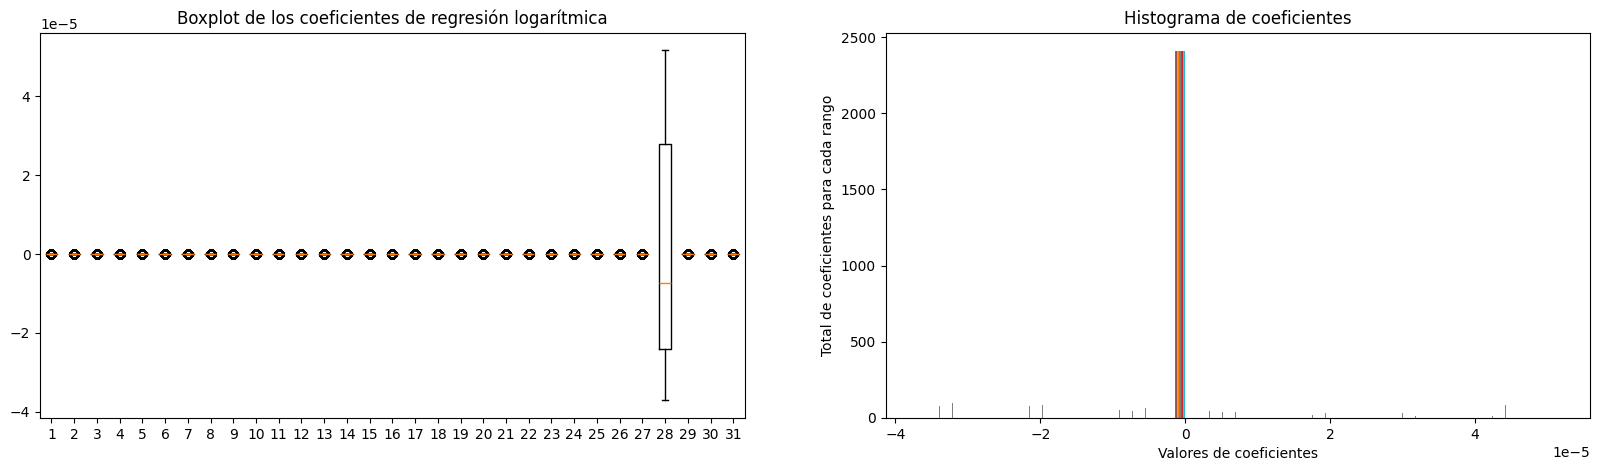

In [56]:
# Graficamos los coeficientes calculados
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.boxplot(model.coef_)
plt.title('Boxplot de los coeficientes de regresión logarítmica')
plt.subplot(1, 2, 2)
plt.hist(model.coef_,50)
plt.xlabel('Valores de coeficientes')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [45]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

MSE: 8124374013489.963
R2 Score: -2222.4001614593567


Los resultados de MSE y R2 Score que has obtenido indican que el modelo de regresión tiene un rendimiento muy deficiente y no es capaz de hacer predicciones precisas.

Cálculo las métricas del modelo

In [38]:
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

In [40]:
# Creamos una función que mida el error en ambos conjuntos y la diferencia
def get_metrics(yhat_test, y_test, yhat_train, y_train):
  metrics_train = r2_score(y_train, yhat_train), median_absolute_error(y_train, yhat_train), mean_absolute_percentage_error(y_train, yhat_train)*100
  metrics_test = r2_score(y_test, yhat_test), median_absolute_error(y_test, yhat_test), mean_absolute_percentage_error(y_test, yhat_test)*100
  metrics_diff = list(map(lambda x: x[1]-x[0], zip(metrics_train, metrics_test)))
  return pd.DataFrame(data=[metrics_train, metrics_test, metrics_diff], columns=['R2', 'Median AE', 'MAPE'], index=['Train set', 'Test set', 'Diferencia'])

In [50]:
get_metrics(yhat_test, y_test, yhat_train, y_train)

,R2,Median AE,MAPE
Train set,-715.31,2867264.50,78055.38
Test set,-2222.40,2868432.50,75384.00
Diferencia,-1507.09,1168.00,-2671.37


Regularización

Lasso 1

In [53]:
# Entrenamos un modelo LassoCV debemos encontrar un buen valor de alpha (determina la intensidad de la regularización) mediante validación cruzada
m_lasso = LassoCV(alphas=np.logspace(-6, 6, 10), cv=5, random_state=42, n_jobs=-1).fit(X_train, y_train)

print(f'Mejor alpha encontrado: {m_lasso.alpha_}')

Mejor alpha encontrado: 1e-06


LassoCV: Este es un estimador de regresión Lasso con validación cruzada incorporada para la selección automática del parámetro de regularización alpha.

alphas=np.logspace(-6, 6, 10): Especifica los valores de alpha que se probarán durante la búsqueda. En este caso, se prueban 10 valores de alpha distribuidos uniformemente en una escala logarítmica de 10^-6 a 10^6.

cv=5: Este parámetro especifica el número de divisiones para la validación cruzada. En este caso, se utiliza una validación cruzada de 5 pliegues.

random_state=42: Establece la semilla aleatoria para reproducibilidad.

n_jobs=-1: Utiliza todos los núcleos de CPU disponibles para paralelizar el proceso de validación cruzada y ajuste de modelos.

El método fit(X_train_sc, y_train) ajusta el modelo de regresión Lasso a los datos de entrenamiento, lo que implica encontrar los coeficientes que minimizan la función de pérdida regularizada (suma de los errores al cuadrado más un término de regularización L1 ponderado por alpha).

Al final del proceso, el modelo entrenado m_lasso contendrá el mejor valor de alpha seleccionado automáticamente y los coeficientes correspondientes a ese valor de alpha.

In [54]:
# Realizamos predicciones con el modelo lasso y los conjuntos de prueba y de testeo.

yhat_train_lasso = m_lasso.predict(X_train)
yhat_lasso = m_lasso.predict(X_test)

In [55]:
get_metrics(yhat_lasso, y_test, yhat_train_lasso, y_train)

,R2,Median AE,MAPE
Train set,1.00,290.84,7.20
Test set,-2222.40,2868432.50,75384.00
Diferencia,-2223.40,2868141.66,75376.80


In [58]:
print(f'Coeficientes: {m_lasso.coef_}')

Coeficientes: [ 5.90072033e+04 -1.41194128e+04 -1.27573031e+03  6.25793841e+02
  2.37305310e+03  2.33446258e+04  5.96780162e+03 -4.16900257e+03
  1.38648866e+04  4.08472860e+03 -9.15977684e+03 -2.13579890e+04
  7.04567178e+03 -1.29543075e+03  4.66353719e+03 -6.83104021e+03
  1.53069998e+04 -6.83738863e+03  1.11366525e+02 -2.66855108e+03
 -1.78239319e+02 -1.37159427e+03 -2.39230587e+02 -1.11975708e+04
  1.92019768e+04 -1.07545872e+04  5.73299812e+04  3.94158707e-01
  1.91564797e+03 -9.44573587e+03 -5.30993099e+04]


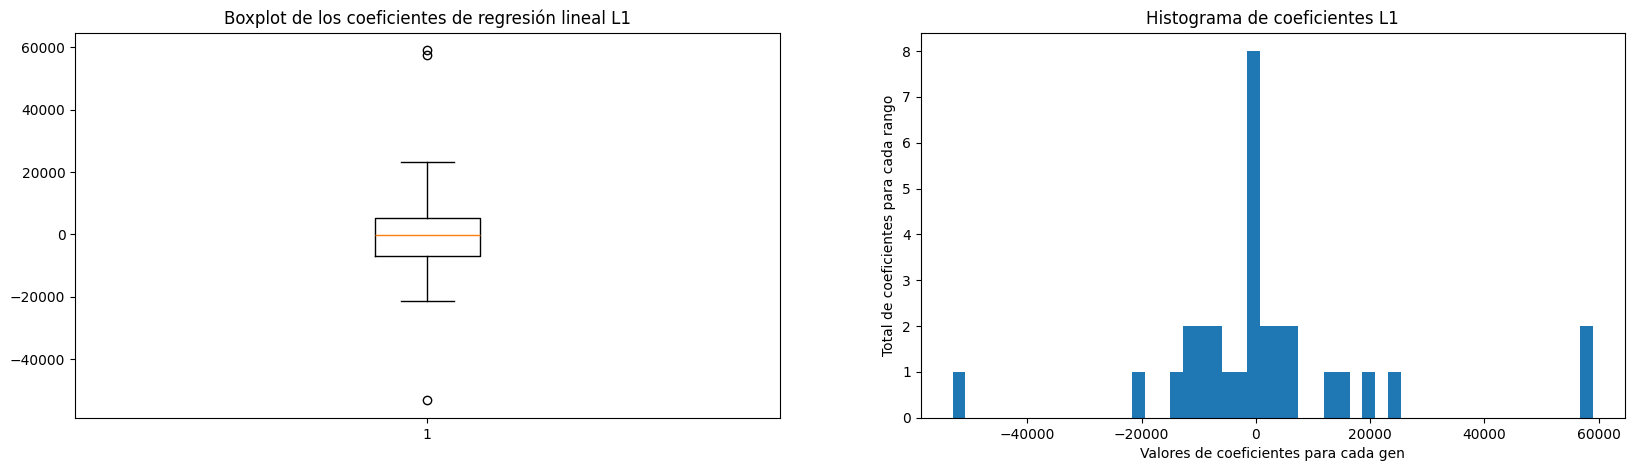

In [70]:
# Coeficientes con el modelo lasso

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.boxplot(m_lasso.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal L1')
plt.subplot(1, 2, 2)
plt.hist(m_lasso.coef_,50)
plt.xlabel('Valores de coeficientes para cada gen')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes L1')
plt.show()

In [59]:
len([x for x in m_lasso.coef_ if np.abs(x)==0])/len(m_lasso.coef_)*100
print(f'El porcentaje de variables canceladas es: {round(len(m_lasso.coef_[np.abs(m_lasso.coef_)==0])/len(m_lasso.coef_)*100,2)}%')
print(f'El modelo utiliza {len(m_lasso.coef_[np.abs(m_lasso.coef_)>0])} variables.')

El porcentaje de variables canceladas es: 0.0%
El modelo utiliza 31 variables.


Lasso 2

In [64]:
# Entrenamos un modelo LassoCV
m_ridge = RidgeCV(alphas=np.logspace(-6, 6, 10), cv=5).fit(X_train, y_train)

In [65]:
yhat_train_ridge = m_ridge.predict(X_train)
yhat_ridge = m_ridge.predict(X_test)

In [66]:
get_metrics(yhat_ridge, y_test, yhat_train_ridge, y_train)

,R2,Median AE,MAPE
Train set,1.00,0.00,0.00
Test set,-2222.40,2868432.50,75384.00
Diferencia,-2223.40,2868432.50,75384.00


In [67]:
print(f'Coeficientes: {m_ridge.coef_}')

Coeficientes: [ 5.19268341e-02 -1.30152555e-02 -1.31647032e-02 -1.54372162e-02
 -1.52545348e-02 -1.35359899e-02 -1.33019069e-02 -1.07483734e-02
 -6.31675334e-03 -3.75640897e-03 -5.43036710e-09  5.19263528e-02
  3.34862845e-07  4.36320435e-07  5.98293339e-07  6.85270405e-07
 -3.40495369e-09  1.17601983e-01 -1.12841462e-01 -4.85701679e-03
  9.48829724e-09  1.03383809e-08 -1.67633945e-08 -4.70594535e-07
 -5.86093431e-08  1.03200560e-05 -3.41382795e-08  1.00000000e+00
 -1.68587814e-08 -5.59453501e-08 -3.19037310e-08]


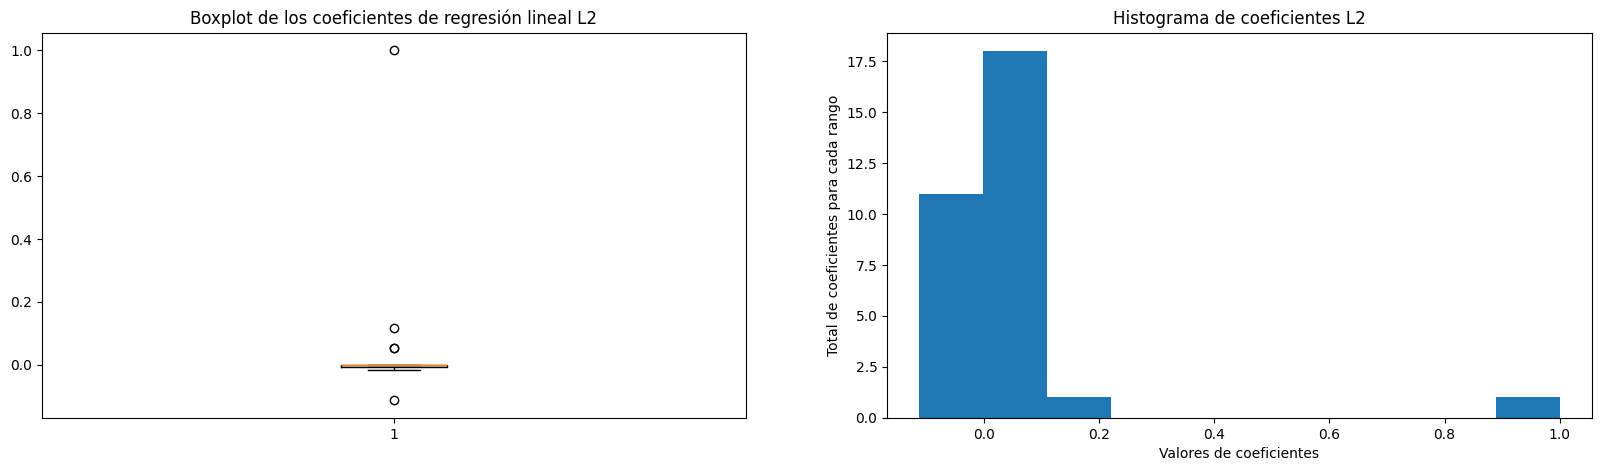

In [69]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.boxplot(m_ridge.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal L2')
plt.subplot(1, 2, 2)
plt.hist(m_ridge.coef_,10)
plt.xlabel('Valores de coeficientes')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes L2')
plt.show()

In [71]:
# Porcentaje de variables canceladas y variables que usa el modelo
print(f'El porcentaje de variables canceladas es: {round(len(m_ridge.coef_[np.abs(m_ridge.coef_)==0])/len(m_ridge.coef_)*100,2)}%')
print(f'El modelo utiliza {len(m_ridge.coef_[np.abs(m_ridge.coef_)>0])} variables.')

El porcentaje de variables canceladas es: 0.0%
El modelo utiliza 31 variables.
